In [1]:
import math
import torch
import triton
import triton.language as tl

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
def rnn_scan_ref(x: torch.Tensor, a: torch.Tensor, h0: torch.Tensor | None = None) -> torch.Tensor:
    h_t = torch.zeros_like(x[:, 0], device=x.device, dtype=x.dtype) if h0 is None else h0
    for t in range(x.shape[1]):
        h_t = a[:, t] * h_t + x[:, t]
    return h_t

---

### Linear scan

In [3]:
def sequential_rnn_scan(x: torch.Tensor, a: torch.Tensor, h0: torch.Tensor | None = None) -> torch.Tensor:
    BLOCK_SIZE, num_warps = 256, 16  # TODO: change later to autotune

    batch, seq_len, dim = x.shape
    assert dim % BLOCK_SIZE == 0, f"{dim=} is not a multiple of {BLOCK_SIZE=}"
    assert x.shape == a.shape
    assert h0 is None or h0.shape == (batch, dim)

    if h0 is None:
        h0 = torch.zeros_like(x[:, 0], device=x.device, dtype=x.dtype)
    out = torch.empty_like(h0)

    grid = lambda META: (batch, triton.cdiv(dim, META["BLOCK_SIZE"]))
    _sequential_rnn_scan_fwd_kernel[grid](
        x_ptr=x,
        a_ptr=a,
        h0_ptr=h0,
        out_ptr=out,
        stride_x_batch=x.stride(0),
        stride_x_len=x.stride(1),
        stride_x_dim=x.stride(2),
        stride_a_batch=a.stride(0),
        stride_a_len=a.stride(1),
        stride_a_dim=a.stride(2),
        stride_h0_batch=h0.stride(0),
        stride_h0_dim=h0.stride(1),
        stride_out_batch=out.stride(0),
        stride_out_dim=out.stride(1),
        seq_len=seq_len,
        BLOCK_SIZE=BLOCK_SIZE,
        num_warps=num_warps,
    )
    return out

In [4]:
@triton.jit
def _sequential_rnn_scan_fwd_kernel(
    x_ptr,
    a_ptr,
    h0_ptr,
    out_ptr,
    stride_x_batch,
    stride_x_len,
    stride_x_dim,
    stride_a_batch,
    stride_a_len,
    stride_a_dim,
    stride_h0_batch,
    stride_h0_dim,
    stride_out_batch,
    stride_out_dim,
    seq_len: tl.constexpr,
    BLOCK_SIZE: tl.constexpr,
):
    # Grid: (batch, dim/BLOCK_SIZE)
    pid_batch = tl.program_id(0)
    pid_dim = tl.program_id(1)

    x_ptr += pid_batch * stride_x_batch
    a_ptr += pid_batch * stride_a_batch
    ht_ptr = h0_ptr + pid_batch * stride_h0_batch
    out_ptr += pid_batch * stride_out_batch

    offsets = pid_dim * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    x_ptrs = x_ptr + offsets * stride_x_dim
    a_ptrs = a_ptr + offsets * stride_a_dim

    ht_ptrs = ht_ptr + offsets * stride_h0_dim
    out_ptrs = out_ptr + offsets * stride_out_dim

    h_t = tl.load(ht_ptrs).to(tl.float32)
    for t in range(seq_len):
        x_t = tl.load(x_ptrs).to(tl.float32)
        a_t = tl.load(a_ptrs).to(tl.float32)

        h_t = a_t * h_t + x_t

        if t < seq_len - 1:
            x_ptrs += stride_x_len
            a_ptrs += stride_a_len

    tl.store(out_ptrs, h_t.to(out_ptr.dtype.element_ty))

In [5]:
batch, seq_len, dim = 10, 256, 256 * 50
x = torch.randn(batch, seq_len, dim).cuda()
a = torch.randn(batch, seq_len, dim).cuda()

torch.allclose(sequential_rnn_scan(x, a), rnn_scan_ref(x, a), atol=0.125, rtol=0)

True

---

### Associative scan

In [6]:
@triton.jit
def _associative_scan_op(a_l, x_l, a_r, x_r):
    return a_r * a_l, a_r * x_l + x_r


@triton.jit
def _associative_rnn_scan_fwd_kernel(
    x_ptr,
    a_ptr,
    cum_a_ptr,
    out_ptr,
    stride_x_batch,
    stride_x_len,
    stride_x_dim,
    stride_a_batch,
    stride_a_len,
    stride_a_dim,
    stride_out_batch,
    stride_out_len,
    stride_out_dim,
    stride_cum_a_batch,
    stride_cum_a_len,
    stride_cum_a_dim,
    BLOCK_SIZE_LEN: tl.constexpr,
    BLOCK_SIZE_DIM: tl.constexpr,
):
    # Grid: (batch, seq_len/BLOCK_SIZE_LEN, dim/BLOCK_SIZE_DIM)
    pid_batch = tl.program_id(0)
    pid_len = tl.program_id(1)
    pid_dim = tl.program_id(2)

    x_ptr += pid_batch * stride_x_batch
    a_ptr += pid_batch * stride_a_batch
    if cum_a_ptr is not None:
        cum_a_ptr += pid_batch * stride_cum_a_batch
    out_ptr += pid_batch * stride_out_batch

    offsets_dim = pid_dim * BLOCK_SIZE_DIM + tl.arange(0, BLOCK_SIZE_DIM)
    offsets_len = pid_len * BLOCK_SIZE_LEN + tl.arange(0, BLOCK_SIZE_LEN)
    x_ptrs = x_ptr + offsets_dim[None, :] * stride_x_dim + offsets_len[:, None] * stride_x_len
    a_ptrs = a_ptr + offsets_dim[None, :] * stride_a_dim + offsets_len[:, None] * stride_a_len

    out_ptrs = out_ptr + offsets_dim[None, :] * stride_out_dim + offsets_len[:, None] * stride_out_len
    if cum_a_ptr is not None:
        cum_a_ptrs = cum_a_ptr + offsets_dim[None, :] * stride_cum_a_dim + offsets_len[:, None] * stride_cum_a_len

    x = tl.load(x_ptrs).to(tl.float32)
    a = tl.load(a_ptrs).to(tl.float32)
    cum_a, all_hiddens = tl.associative_scan(input=(a, x), axis=0, combine_fn=_associative_scan_op)

    mask = (offsets_len == ((pid_len + 1) * BLOCK_SIZE_LEN - 1))[:, None]
    if cum_a_ptr is not None:
        tl.store(cum_a_ptrs, cum_a.to(cum_a_ptr.dtype.element_ty), mask=mask)
    tl.store(out_ptrs, all_hiddens.to(out_ptr.dtype.element_ty), mask=mask)

In [7]:
def associative_rnn_scan(x: torch.Tensor, a: torch.Tensor) -> torch.Tensor:
    BLOCK_SIZE_LEN, BLOCK_SIZE_DIM, num_warps = 32, 256, 16  # TODO: change later to autotune

    batch, seq_len, dim = x.shape
    assert seq_len % BLOCK_SIZE_LEN == 0, f"{seq_len=} is not a multiple of {BLOCK_SIZE_LEN=}"
    assert dim % BLOCK_SIZE_DIM == 0, f"{dim=} is not a multiple of {BLOCK_SIZE_DIM=}"
    assert x.shape == a.shape

    out = torch.zeros_like(x)
    cum_a = torch.zeros_like(x)

    num_iters = int(triton.cdiv(math.log2(out.shape[1]), math.log2(BLOCK_SIZE_LEN)))
    for iter_id in range(num_iters):
        grid = lambda META: (batch, max(1, triton.cdiv(out.shape[1], META["BLOCK_SIZE_LEN"])), triton.cdiv(dim, META["BLOCK_SIZE_DIM"]))
        _associative_rnn_scan_fwd_kernel[grid](
            x_ptr=x,
            a_ptr=a,
            cum_a_ptr=cum_a if iter_id != num_iters - 1 else None,
            out_ptr=out,
            stride_x_batch=x.stride(0),
            stride_x_len=x.stride(1),
            stride_x_dim=x.stride(2),
            stride_a_batch=a.stride(0),
            stride_a_len=a.stride(1),
            stride_a_dim=a.stride(2),
            stride_out_batch=out.stride(0),
            stride_out_len=out.stride(1),
            stride_out_dim=out.stride(2),
            stride_cum_a_batch=cum_a.stride(0) if iter_id != num_iters - 1 else None,
            stride_cum_a_len=cum_a.stride(1) if iter_id != num_iters - 1 else None,
            stride_cum_a_dim=cum_a.stride(2) if iter_id != num_iters - 1 else None,
            BLOCK_SIZE_LEN=BLOCK_SIZE_LEN if iter_id != num_iters - 1 else out.shape[1],
            BLOCK_SIZE_DIM=BLOCK_SIZE_DIM,
            num_warps=num_warps,
        )
        if iter_id != num_iters - 1:
            out = out[:, BLOCK_SIZE_LEN - 1 :: BLOCK_SIZE_LEN]
            cum_a = cum_a[:, BLOCK_SIZE_LEN - 1 :: BLOCK_SIZE_LEN]
            x, a = out, cum_a
    return out[:, -1]

In [8]:
batch, seq_len, dim = 100, 256, 256 * 10
x = torch.randn(batch, seq_len, dim, dtype=torch.float32).cuda()
a = torch.randn(batch, seq_len, dim, dtype=torch.float32).cuda()

torch.allclose(associative_rnn_scan(x, a), rnn_scan_ref(x, a), atol=0.125, rtol=0)

True


---

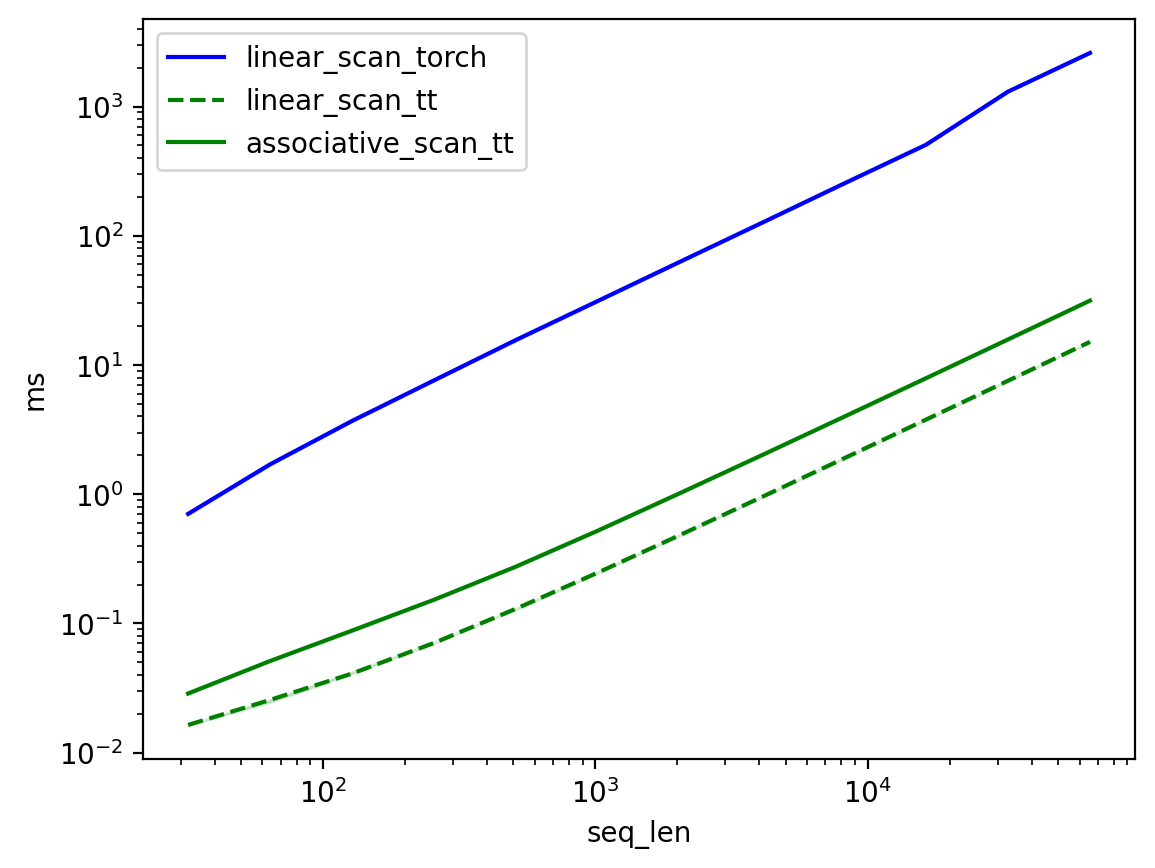

rnn_scan_performance:
    seq_len  linear_scan_torch  linear_scan_tt  associative_scan_tt
0      32.0           0.704512        0.016384             0.028672
1      64.0           1.702912        0.025600             0.051200
2     128.0           3.689984        0.040960             0.088064
3     256.0           7.605248        0.070656             0.152576
4     512.0          15.630336        0.130048             0.275456
5    1024.0          31.342592        0.247808             0.523264
6    2048.0          62.939137        0.483328             1.019904
7    4096.0         126.058495        0.952832             2.007040
8    8192.0         253.567993        1.895424             3.975168
9   16384.0         506.063873        3.779584             7.901184
10  32768.0        1303.896118        7.549440            15.759872
11  65536.0        2598.876221       15.088640            31.484928


In [9]:
@triton.testing.perf_report(
    [
        triton.testing.Benchmark(
            x_names=["seq_len"],
            x_vals=[2**i for i in range(5, 17, 1)],
            x_log=True,
            y_log=True,
            line_arg="benchmark_fn",
            line_vals=["rnn_scan_ref", "sequential_rnn_scan", "associative_rnn_scan"],
            line_names=["linear_scan_torch", "linear_scan_tt", "associative_scan_tt"],
            styles=[("blue", "-"), ("green", "--"), ("green", "-")],
            ylabel="ms",
            plot_name="rnn_scan_performance",
            args={"batch": 8, "dim": 2560},
        )
    ]
)

def benchmark(batch: int, seq_len: int, dim: int, benchmark_fn: str):
    x = torch.randn(batch, seq_len, dim, device="cuda", dtype=torch.float32)
    a = torch.randn(batch, seq_len, dim, device="cuda", dtype=torch.float32)

    quantiles = [0.5, 0.2, 0.8]
    return triton.testing.do_bench(lambda: globals()[benchmark_fn](x, a), quantiles=quantiles)

benchmark.run(show_plots=True, print_data=True)